### Import all the Dependencies

In [74]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import scipy
from sklearn.metrics import precision_score, recall_score, f1_score

### Import data into tensorflow dataset object

Used splitfolders tool to split dataset into training, validation and test directories.

$ pip install split-folders

$ splitfolders --ratio 0.8 0.1 0.1 -- ./training/PlantVillage/


In [75]:
IMAGE_SIZE = 256
CHANNELS = 3

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
#         
)

Found 9322 images belonging to 18 classes.


In [ ]:
train_generator.class_indices

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

In [ ]:
count=0
for image_batch, label_batch in train_generator:
#     print(label_batch)
    print(image_batch[0])
    break
#     count+=1
#     if count>2:
#         break

In [77]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'dataset/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 1160 images belonging to 18 classes.


In [78]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 1178 images belonging to 18 classes.


In [32]:
for image_batch, label_batch in test_generator:
    print(image_batch[0])
    break

[[[0.86666673 0.8980393  0.94117653]
  [0.86666673 0.8980393  0.94117653]
  [0.86666673 0.8980393  0.94117653]
  ...
  [0.8196079  0.8588236  0.9058824 ]
  [0.8190909  0.8583066  0.9053654 ]
  [0.81518006 0.8543958  0.9014546 ]]

 [[0.9372576  0.9658065  0.98353106]
  [0.92999583 0.95883524 0.979174  ]
  [0.92273414 0.951864   0.97481704]
  ...
  [0.8196079  0.8588236  0.9058824 ]
  [0.81880045 0.85801613 0.90507495]
  [0.8148896  0.8541053  0.9011642 ]]

 [[0.9618931  0.98934406 1.        ]
  [0.9621836  0.9896346  1.        ]
  [0.96247405 0.989925   1.        ]
  ...
  [0.8196079  0.8588236  0.9058824 ]
  [0.81851    0.8577257  0.9047845 ]
  [0.81459916 0.85381484 0.9008737 ]]

 ...

 [[0.46026197 0.44288608 0.30907324]
  [0.49255547 0.4768692  0.31230152]
  [0.47351146 0.45119405 0.27251303]
  ...
  [0.45942298 0.4437367  0.431972  ]
  [0.4582611  0.44257483 0.43081012]
  [0.45709926 0.441413   0.42964828]]

 [[0.46810463 0.4510192  0.31459215]
  [0.49081266 0.4751264  0.3085254 ]


## Building the Model

In [79]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [14]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator):
        super(MetricsCallback, self).__init__()
        self.validation_generator = validation_generator

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = self.model.predict(self.validation_generator)
        val_true = self.validation_generator.labels

        val_precision = precision_score(val_true, val_predictions.argmax(axis=1), average='weighted')
        val_recall = recall_score(val_true, val_predictions.argmax(axis=1), average='weighted')
        val_f1 = f1_score(val_true, val_predictions.argmax(axis=1), average='weighted')

        logs['val_precision'] = val_precision
        logs['val_recall'] = val_recall
        logs['val_f1'] = val_f1
        print(f"val_precision: {val_precision}, val_recall: {val_recall}, val_f1: {val_f1}")

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [80]:
9000/32

281.25

In [81]:
1000/32

31.25

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=281,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=31,
    verbose=1,
    epochs=100,
    callbacks=[MetricsCallback(validation_generator)],
)

Epoch 1/100
118/118 [==============================] - 56s 433ms/step - loss: 0.8520 - accuracy: 0.6466 - val_loss: 0.4248 - val_accuracy: 0.8683
val_precision: 0.28260953029819286, val_recall: 0.2824267782426778, val_f1: 0.28233761102691063
Epoch 2/100
118/118 [==============================] - 49s 418ms/step - loss: 0.3207 - accuracy: 0.8909 - val_loss: 0.2308 - val_accuracy: 0.9219
val_precision: 0.23912189699209893, val_recall: 0.2384937238493724, val_f1: 0.23875698858997618
Epoch 3/100
118/118 [==============================] - 49s 417ms/step - loss: 0.2059 - accuracy: 0.9302 - val_loss: 0.2629 - val_accuracy: 0.9040
val_precision: 0.24657548049438277, val_recall: 0.2384937238493724, val_f1: 0.24121472027826682
Epoch 4/100
118/118 [==============================] - 49s 416ms/step - loss: 0.1628 - accuracy: 0.9440 - val_loss: 0.2477 - val_accuracy: 0.9353
val_precision: 0.2633743845841279, val_recall: 0.2615062761506276, val_f1: 0.2616759062105715
Epoch 5/100
118/118 [=============

In [19]:
scores = model.evaluate(test_generator)

15/15 [==============================] - 6s 378ms/step - loss: 0.0248 - accuracy: 0.9937


In [26]:
scores

[0.024847712367773056, 0.9937499761581421]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [20]:
history

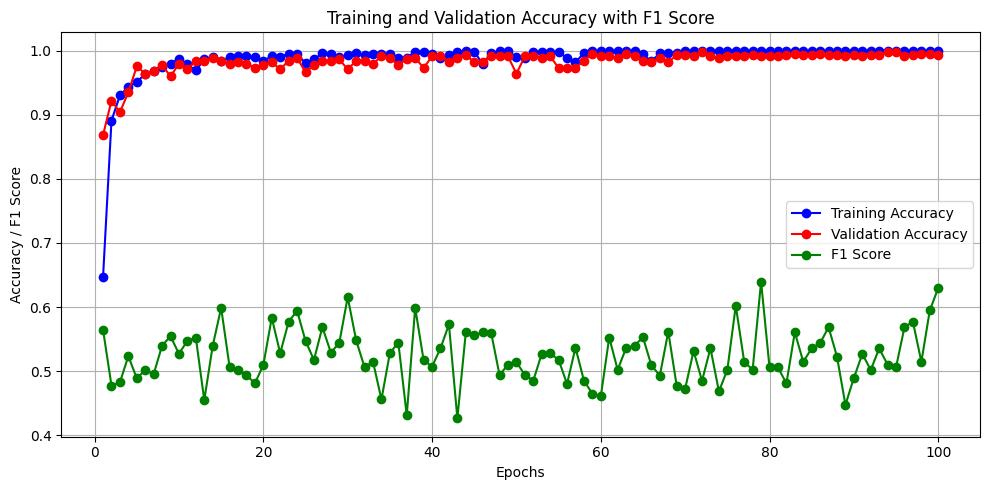

In [70]:
import matplotlib.pyplot as plt

# Extracting accuracy, loss, and f1 score values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_scores = history.history['val_f1']

epochs = range(1, len(acc) + 1)

# Plotting accuracy and F1 score
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy', color='blue', marker='o')  # Add circles to indicate points
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', marker='o')  # Add circles to indicate points
plt.plot(epochs, f1_scores, label='F1 Score', color='green', marker='o')  # Add circles to indicate points
plt.title('Training and Validation Accuracy with F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / F1 Score')
plt.tight_layout() 
plt.legend()
plt.grid(True)
plt.show()




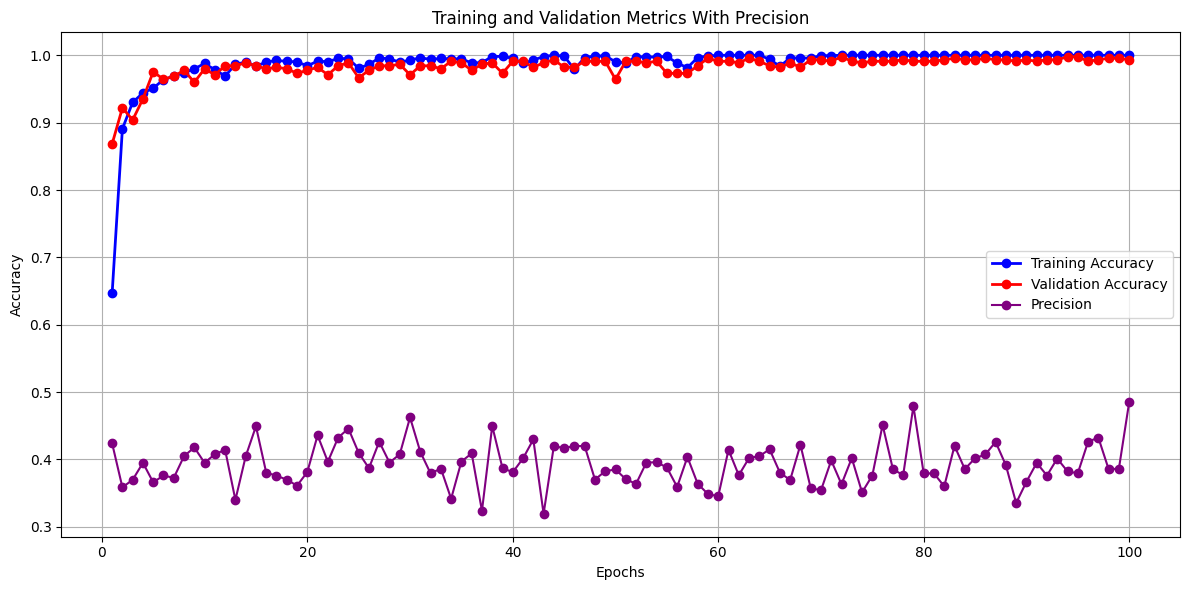

In [57]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precisions =  history.history['val_precision']
f1_scores = history.history['val_f1']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, label='Training Accuracy', color='blue', marker='o', linewidth=2)  
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', marker='o', linewidth=2) 
plt.plot(epochs, precisions, label='Precision', color='purple', marker='o')  # Add circles to indicate points

plt.title('Training and Validation Metrics With Precision')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout() 
plt.grid(True)
plt.show()



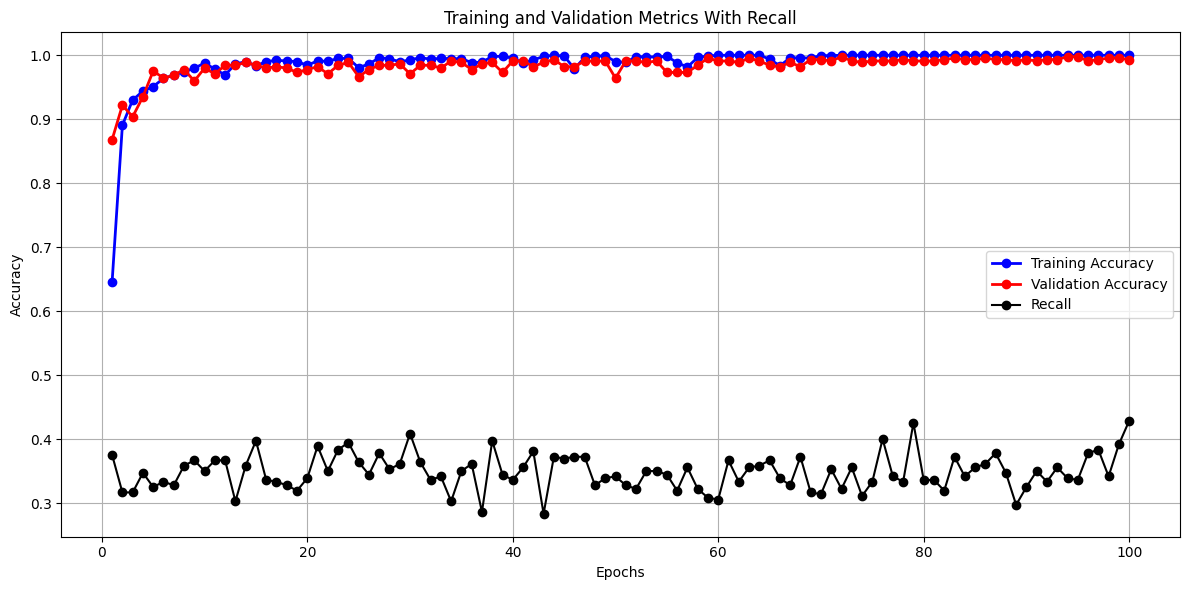

In [68]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precisions =  history.history['val_precision']
f1_scores = history.history['val_f1']
recalls = istory.history['val_recall']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, label='Training Accuracy', color='blue', marker='o', linewidth=2)  
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', marker='o', linewidth=2) 
plt.plot(epochs, recalls, label='Recall', color='black', marker='o')  # Add circles to indicate points

plt.title('Training and Validation Metrics With Recall')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout() 
plt.grid(True)
plt.show()



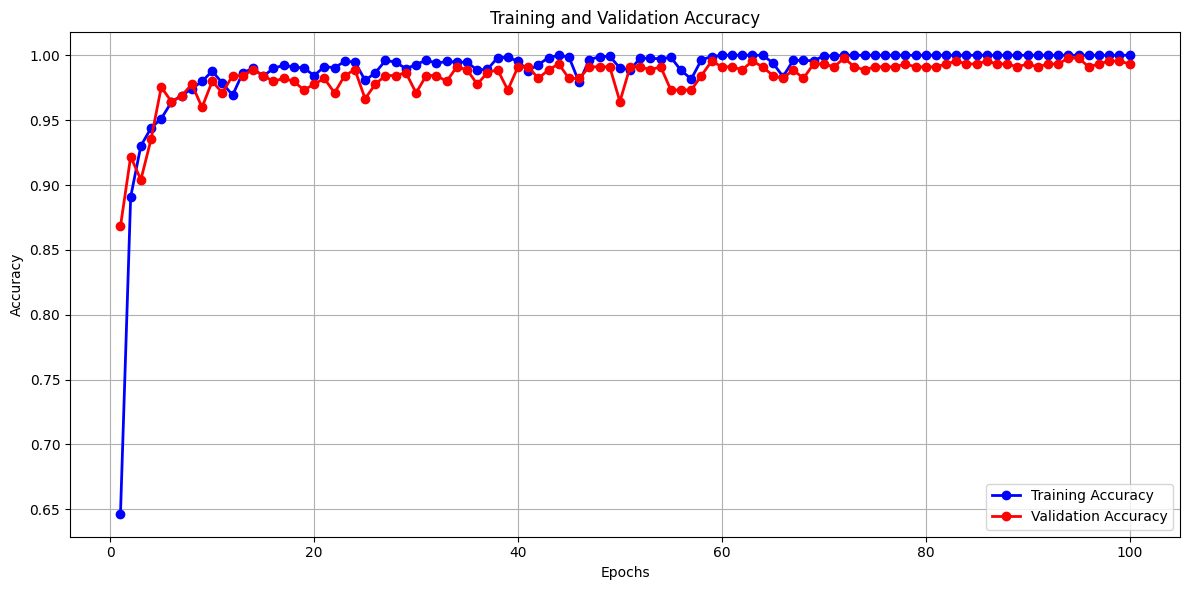

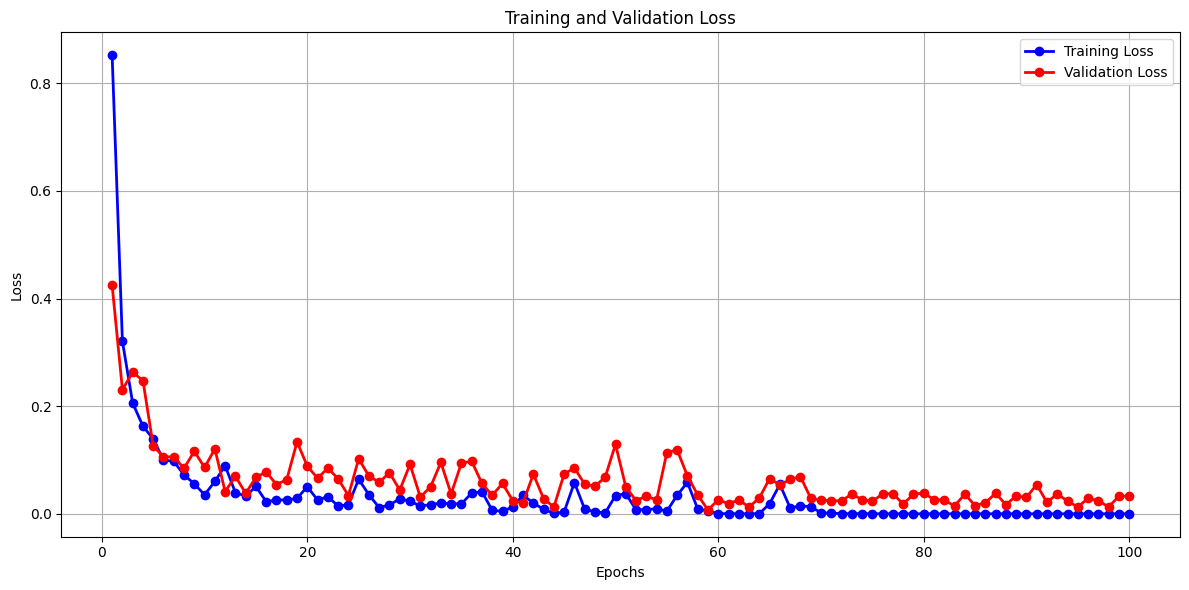

In [44]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, label='Training Accuracy', color='blue', marker='o', linewidth=2)  
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', marker='o', linewidth=2)  
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, label='Training Loss', color='blue', marker='o', linewidth=2)  
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o', linewidth=2)  
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()


In [55]:
precisions 

[0.28260953029819286,
 0.23912189699209893,
 0.24657548049438277,
 0.2633743845841279,
 0.24403449133919664,
 0.25085489517071174,
 0.24848237069563442,
 0.26997128923558494,
 0.2786280114506539,
 0.2633220277027276,
 0.2719605348390755,
 0.276164212356681,
 0.22668858338314407,
 0.2697449130746906,
 0.2995048752934226,
 0.2536452782874776,
 0.2506623897512434,
 0.24669911779244144,
 0.24076003675238694,
 0.25428791997909,
 0.2905602915693981,
 0.26444301248017715,
 0.2883016788849324,
 0.2972784302005321,
 0.27324126735891646,
 0.2580635489305999,
 0.28427444736549784,
 0.26362552285982216,
 0.2718261055335197,
 0.3082737868825735,
 0.2741933854667514,
 0.25288679789380525,
 0.25770821329498045,
 0.22787226720281115,
 0.2646330541879004,
 0.27271185582408514,
 0.21586310358974237,
 0.2997939992795126,
 0.25810359477809036,
 0.2540981244342545,
 0.26778242677824265,
 0.2864686888289835,
 0.21293381869354547,
 0.2800219770931068,
 0.27787894247974326,
 0.28007433186189556,
 0.2799401925

In [52]:
recalls 

[0.2824267782426778,
 0.2384937238493724,
 0.2384937238493724,
 0.2615062761506276,
 0.24476987447698745,
 0.2510460251046025,
 0.24686192468619247,
 0.2698744769874477,
 0.27615062761506276,
 0.26359832635983266,
 0.27615062761506276,
 0.27615062761506276,
 0.2280334728033473,
 0.2698744769874477,
 0.29916317991631797,
 0.25313807531380755,
 0.2510460251046025,
 0.24686192468619247,
 0.2405857740585774,
 0.25523012552301255,
 0.2928870292887029,
 0.26359832635983266,
 0.28870292887029286,
 0.29707112970711297,
 0.27405857740585776,
 0.2594142259414226,
 0.28451882845188287,
 0.26569037656903766,
 0.2719665271966527,
 0.3075313807531381,
 0.27405857740585776,
 0.25313807531380755,
 0.25732217573221755,
 0.2280334728033473,
 0.26359832635983266,
 0.2719665271966527,
 0.21548117154811716,
 0.29916317991631797,
 0.2594142259414226,
 0.25313807531380755,
 0.26778242677824265,
 0.28661087866108786,
 0.21338912133891214,
 0.2803347280334728,
 0.27824267782426776,
 0.2803347280334728,
 0.2803

In [53]:
f1_scores 

[0.28233761102691063,
 0.23875698858997618,
 0.24121472027826682,
 0.2616759062105715,
 0.24438158371228702,
 0.2508970929913249,
 0.24763919330228476,
 0.26987864009169266,
 0.27725728948900874,
 0.2634538260465865,
 0.2738156180534534,
 0.27609895633468234,
 0.2273359512681415,
 0.26980316127750037,
 0.2993049657555294,
 0.253329536624222,
 0.2508482732716772,
 0.2467761865190393,
 0.24052244121121236,
 0.2547374118440635,
 0.2916510770157149,
 0.263976047913317,
 0.28849534855716386,
 0.2971642482128763,
 0.27359317925867266,
 0.2586607781106876,
 0.2843940612139331,
 0.26452569787048025,
 0.271884208023377,
 0.30772072072651996,
 0.2740974276741389,
 0.25299619836825216,
 0.2573769766425264,
 0.22790834924113962,
 0.264077599478185,
 0.27227561107968956,
 0.2156401377295083,
 0.2994397102579675,
 0.2584984421141145,
 0.25354533242435706,
 0.26778242677824265,
 0.28642608435761424,
 0.2131522386129115,
 0.2801761730528237,
 0.27803930548620936,
 0.28014456068539473,
 0.2801236988217

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [138]:
type(history.history['loss'])

list

In [139]:
len(history.history['loss'])

20

In [140]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.30121827125549316,
 0.2505233585834503,
 0.20021991431713104,
 0.18970078229904175,
 0.13964925706386566]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [49]:
val_acc

[0.8683035969734192,
 0.921875,
 0.9040178656578064,
 0.9352678656578064,
 0.9754464030265808,
 0.9642857313156128,
 0.96875,
 0.9776785969734192,
 0.9598214030265808,
 0.9799107313156128,
 0.9709821343421936,
 0.984375,
 0.984375,
 0.9888392686843872,
 0.984375,
 0.9799107313156128,
 0.9821428656578064,
 0.9799107313156128,
 0.9732142686843872,
 0.9776785969734192,
 0.9821428656578064,
 0.9709821343421936,
 0.984375,
 0.9888392686843872,
 0.9665178656578064,
 0.9776785969734192,
 0.984375,
 0.984375,
 0.9866071343421936,
 0.9709821343421936,
 0.984375,
 0.984375,
 0.9799107313156128,
 0.9910714030265808,
 0.9888392686843872,
 0.9776785969734192,
 0.9866071343421936,
 0.9888392686843872,
 0.9732142686843872,
 0.9910714030265808,
 0.9910714030265808,
 0.9821428656578064,
 0.9888392686843872,
 0.9933035969734192,
 0.9821428656578064,
 0.9821428656578064,
 0.9910714030265808,
 0.9910714030265808,
 0.9910714030265808,
 0.9642857313156128,
 0.9910714030265808,
 0.9910714030265808,
 0.988839

In [50]:
val_loss

[0.4248276650905609,
 0.23076750338077545,
 0.26290759444236755,
 0.2476687878370285,
 0.12613163888454437,
 0.10605060309171677,
 0.1055598109960556,
 0.08459712564945221,
 0.11627259105443954,
 0.08603136241436005,
 0.12063563615083694,
 0.04140561446547508,
 0.06978669762611389,
 0.038055021315813065,
 0.0677700787782669,
 0.07776068150997162,
 0.05424616113305092,
 0.06358982622623444,
 0.1335957944393158,
 0.08853203803300858,
 0.06606888771057129,
 0.08494414389133453,
 0.06517328321933746,
 0.033735476434230804,
 0.10226433724164963,
 0.0700945258140564,
 0.05860865116119385,
 0.07629060745239258,
 0.04414884001016617,
 0.09188784658908844,
 0.031023060902953148,
 0.05026673525571823,
 0.09533430635929108,
 0.036970432847738266,
 0.09412794560194016,
 0.09777895361185074,
 0.056356050074100494,
 0.034382887184619904,
 0.05641663819551468,
 0.024327397346496582,
 0.020192941650748253,
 0.07387189567089081,
 0.028108209371566772,
 0.012619213201105595,
 0.07389658689498901,
 0.085

In [165]:
acc

[0.8953797221183777,
 0.9091874957084656,
 0.930164635181427,
 0.9306957125663757,
 0.9507415294647217,
 0.9484864473342896,
 0.9338821172714233,
 0.9535316228866577,
 0.9572490453720093,
 0.9596388936042786,
 0.9731810688972473,
 0.9729155898094177,
 0.9751059412956238,
 0.9763674736022949,
 0.9811471104621887,
 0.9827402830123901,
 0.9774296283721924,
 0.9877854585647583,
 0.9766330122947693,
 0.9872543811798096]

In [166]:
loss


[0.30121827125549316,
 0.2505233585834503,
 0.20021991431713104,
 0.18970078229904175,
 0.13964925706386566,
 0.14428772032260895,
 0.18231278657913208,
 0.13268788158893585,
 0.12059544026851654,
 0.11403750628232956,
 0.0840562954545021,
 0.08145297318696976,
 0.07322809100151062,
 0.06268613785505295,
 0.05103680118918419,
 0.050272781401872635,
 0.07572156935930252,
 0.03639382869005203,
 0.060124773532152176,
 0.04055166617035866]

### Run prediction on a sample image

first image to predict
actual label: Apple___healthy
predicted label: Apple___healthy


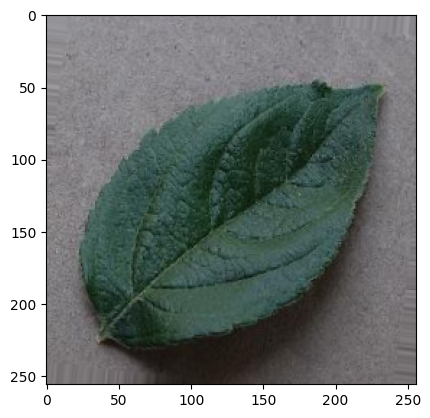

In [24]:
import numpy as np

for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])  # Change labels_batch to label_batch
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)  # Change images_batch to image_batch
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    break

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [ ]:
model.save("./modelver4.h5")

In [ ]:
import tensorflow as tf
#store .h5 file in your .py folder

#load h5 module
model=tf.keras.models.load_model('modelver4.h5')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

#convert
tflite_model = tflite_converter.convert()
open("modelver3.tflite", "wb").write(tflite_model) #RENAME TFLITE MODEL NAME

#done convertion

In [ ]:
model = tf.keras.models.load_model("5")

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

pb_model_dir = r"C:\Users\admin\Desktop\all projects\PPDUC\training\5"
h5_model = "./mymodel.h5"

# Loading the Tensorflow Saved Model (PB)
model = tf.keras.models.load_model(pb_model_dir)
print(model.summary())

# Saving the Model in H5 Format
tf.keras.models.save_model(model, h5_model)

# Loading the H5 Saved Model
loaded_model_from_h5 = tf.keras.models.load_model(h5_model)
print(loaded_model_from_h5.summary())
